In [75]:
from util.experiment_setup import load_model
from matplotlib import pyplot as plt
import seaborn as sns
from util.activation_visualization import effective_receptive_field, rescaleZeroOne
from torchvision.transforms import functional as F
import numpy as np

In [447]:
model = load_model("../models/bg_transform/retinal_base_scale0.5-3")
model = model.get_sequential()
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ELU(alpha=1.0, inplace=True)
  (2): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ELU(alpha=1.0, inplace=True)
  (5): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (7): ELU(alpha=1.0, inplace=True)
  (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (9): ELU(alpha=1.0, inplace=True)
  (10): AdaptiveMaxPool2d(output_size=(2, 3))
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=384, out_features=128, bias=True)
  (13): ELU(alpha=1.0, inplace=True)
  (14): Linear(in_features=128, out_features=128, bias=True)
  (15): ELU(alpha=1.0, inplace=True)
  (16): Linear(in_features=128, out_features=10, bias=True)
  (17): Softmax(dim=-1)
)

In [449]:
cur_layer = 6
prev_layer = 3

In [450]:
eff_rfs = effective_receptive_field(model[:prev_layer+2], n_batch=1, fill_value=0.5, device="cuda")
prev_layer_rfs = [F.to_pil_image(rescaleZeroOne(eff_rf)) for eff_rf in eff_rfs]

eff_rfs = effective_receptive_field(model[:cur_layer+2], n_batch=1, fill_value=0.5, device="cuda")
cur_layer_rfs = [F.to_pil_image(rescaleZeroOne(eff_rf)) for eff_rf in eff_rfs]

100%|██████████| 32/32 [00:00<00:00, 322.59it/s]


In [451]:
connectivity_matrix = model[cur_layer].weight.detach().cpu().abs().sum(axis=(-1,-2)).numpy()
spd_factor = int(connectivity_matrix.shape[1]/len(prev_layer_rfs))
connectivity_matrix = connectivity_matrix.reshape(-1,spd_factor).sum(axis=-1).reshape(connectivity_matrix.shape[0],int(connectivity_matrix.shape[1]/spd_factor))

In [452]:
reorder_x = np.argsort(connectivity_matrix.sum(axis=1))[::-1]

In [453]:
reorder_y = np.argsort(connectivity_matrix.sum(axis=0))[::-1]

[0.1275 0.11   0.8975 0.88  ]


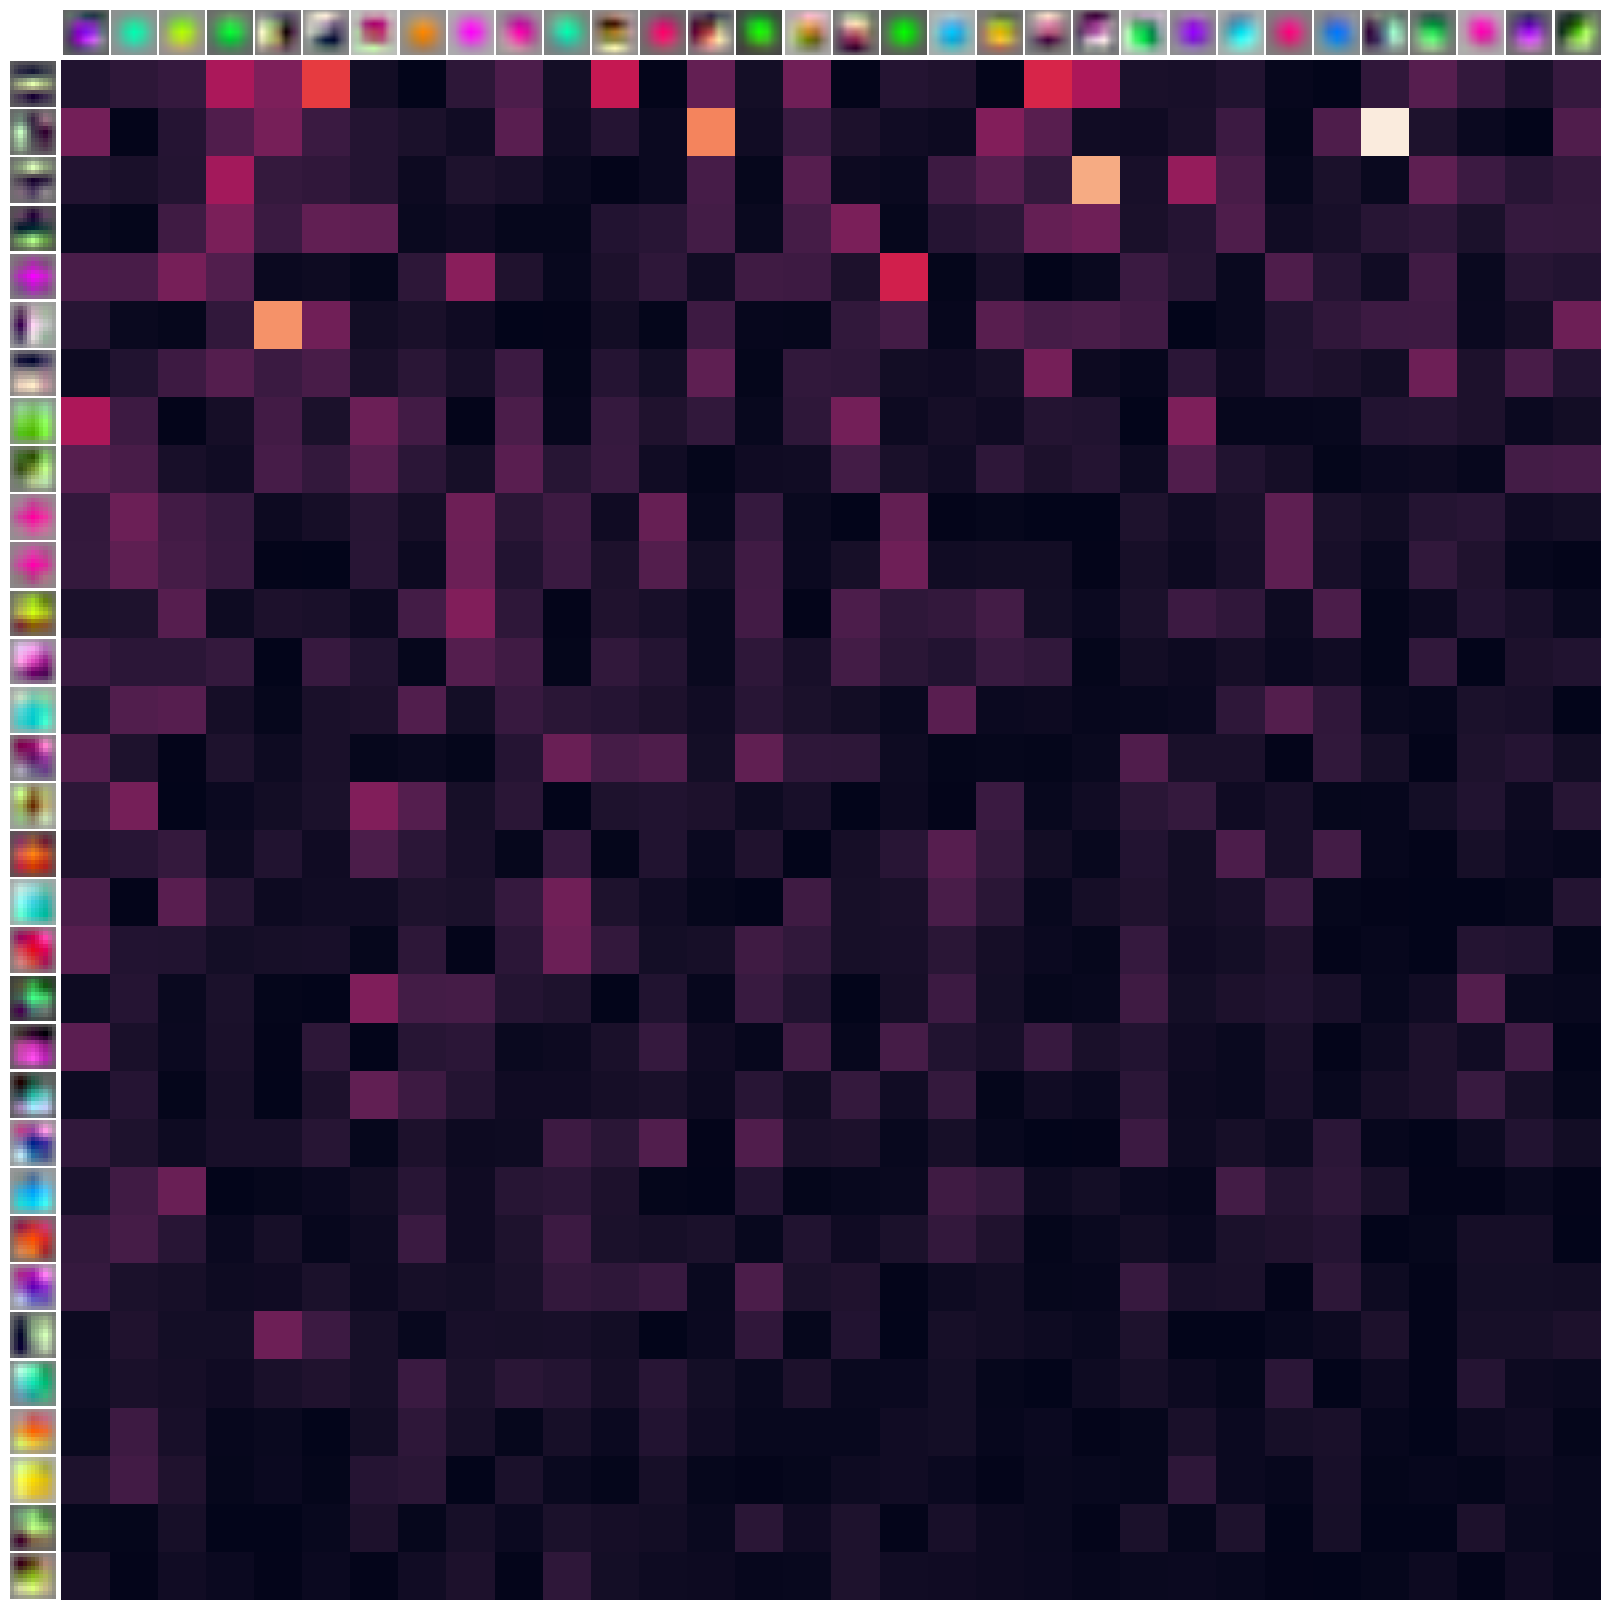

In [454]:
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(connectivity_matrix[reorder_x].T[reorder_y], square=True, xticklabels=[], yticklabels=[], cbar=False)
relabel_axis_with_images(fig, ax, np.array(cur_layer_rfs)[reorder_x], np.array(prev_layer_rfs)[reorder_y])

In [455]:
np.array(ax.get_position()).ravel()

array([0.1275, 0.11  , 0.8975, 0.88  ])

In [456]:
def relabel_axis_with_images(fig, ax, x_images, y_images):
    print(np.array(ax.get_position()).ravel())
    xl, yl, xh, yh=np.array(ax.get_position()).ravel()
    w=xh-xl
    h=yh-yl

    h_step = h/len(y_images)
    w_step = w/len(x_images)
    size = h_step * 0.95

    yp = yh + 0.5 * h_step
    for img in y_images:
        yp=yp-h_step

        ax1=fig.add_axes([xl-0.5*w_step-size*0.6, yp-size*0.5, size, size])
        ax1.axison = False
        imgplot = ax1.imshow(img)

    xp = xl-0.5*w_step
    for img in x_images:
        xp=xp+w_step

        ax1=fig.add_axes([xp-size*0.5, yh+0.1*size, size, size])
        ax1.axison = False
        imgplot = ax1.imshow(img)